<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Structured_House_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [ ]:
import pandas as pd
import tensorflow as tf
import autokeras as ak

# Data Preprocessing
Autokeras預設前處理方式:
1. Numerical --> normalization to (0~1)
2. class --> one-hot encoding
3. NaN --> 0

In [ ]:
df = pd.read_csv('https://github.com/ageron/handson-ml/raw/master/datasets/housing/housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
x = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']
y.describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [ ]:
# 房價差距過大,為避免離群值影響到模型收斂,故更換房價單位(十萬美元)
x = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']/100000
y.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: median_house_value, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

# metric預設採MSE,但這裡指定MAE
reg = ak.StructuredDataRegressor(metrics=['mae'], max_trials=3)
reg.fit(x_train, y_train, callbacks=callbacks)

Trial 3 Complete [00h 00m 20s]
val_loss: 1.0689772367477417

Best val_loss So Far: 0.3239123523235321
Total elapsed time: 00h 05m 34s
INFO:tensorflow:Oracle triggered exit
516/516 [==============================] - 5s 8ms/step - loss: 0.8831 - mae: 0.6576
INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets


# Evaluate

In [ ]:
reg.evaluate(x_test, y_test)

129/129 [==============================] - 1s 4ms/step - loss: 0.5212 - mae: 0.5202


[0.5212118029594421, 0.520174503326416]

# Predict

In [ ]:
predicted = reg.predict(x_test).flatten() * 100000
real = y_test.to_numpy() * 100000

for i in range(10):
    print('Predicted:', predicted[i].round(3))
    print('Real:', real[i].round(0))
    print('')

129/129 [==============================] - 0s 3ms/step
Predicted: 51109.689
Real: 47700.0

Predicted: 96091.139
Real: 45800.0

Predicted: 288958.049
Real: 500001.0

Predicted: 260495.71
Real: 218600.0

Predicted: 216406.25
Real: 278000.0

Predicted: 160776.126
Real: 158700.0

Predicted: 238270.521
Real: 198200.0

Predicted: 180855.429
Real: 157500.0

Predicted: 271877.193
Real: 340000.0

Predicted: 392123.747
Real: 446600.0



In [16]:
# R2 Score 衡量模型預測能力的指標之一
# R2 Score介於0~1之間, 越接近1表模型解釋力越強

from sklearn.metrics import r2_score
r2_score(real, predicted).round(3)

0.602

In [18]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 9)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

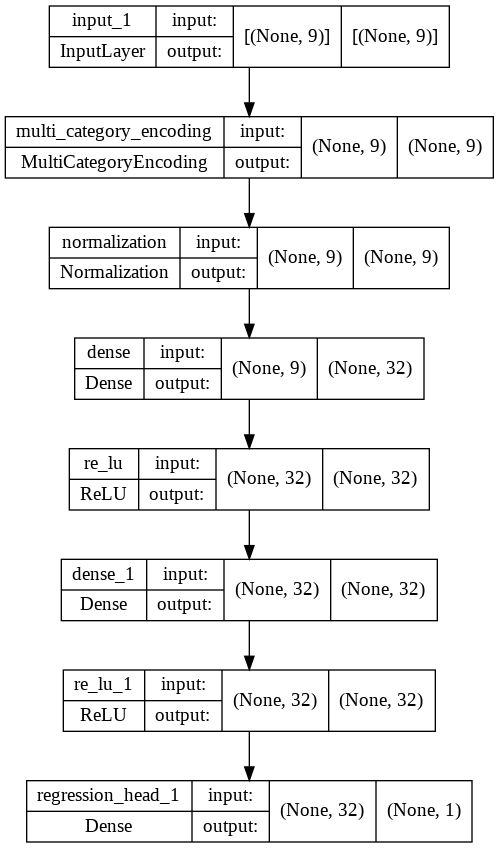

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)